In [1]:
! pip install soundfile

In [2]:
import os
import soundfile as sf
from sklearn.metrics import f1_score
import tables
from mido import Message, MidiFile, MidiTrack, MAX_PITCHWHEEL
import sys
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/multipitch_estimation')
# PERIOD = 6144
PERIOD = 4096

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
% run config.py

import numpy as np
import tables
import os
import pytz
from IPython.display import clear_output
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import keras.backend as K
import datetime
import seaborn as sns
import soundfile as sf
sns.set(font_scale=1.5)

In [0]:
% run base_model.ipynb

In [5]:
% run translation_invariant_model.ipynb

Using TensorFlow backend.


In [0]:
''' 
.wav файл считывается библиотекой Soundfile как многомерный массив с шейпом (None, sound_channels)
Данная функция преобразует только двухканальные аудиофайлы: сливает их в один канал.
Остальные (не двухканальные) аудиофайлы оставляет неизменными.
'''
def make_mono_audiofile(data):
    if len(data.shape) == 1:
        return data
    if data.shape[1] == 2:
        data = (data[:, 0] + data[:,1]) / 2
    return data


def normalize_data(X):
    X /= np.linalg.norm(X, axis=1, keepdims=True)
    return X

def collect_specific_files(subname, file_triplets):
    result = []
    for triplet in file_triplets:
        filename = triplet[0]
        if filename.startswith(subname):
            result.append(triplet)
    return np.array(result)
   
def find_original_tempo(filename_mid):
    mid = MidiFile(filename_mid)
    tmp_msg = []
    for msg in mid:
        if msg.is_meta and msg.type=='set_tempo':
            tmp_msg = msg
    return mid.ticks_per_beat, tmp_msg.tempo


        

In [0]:
def find_best_threshold_for_test(model, sess):
    f_X_test = tables.open_file('X_test_mus.h5', mode='r')
    f_y_test = tables.open_file('y_test_mus.h5', mode='r')
    X_test = f_X_test.root.data
    y_test = f_y_test.root.data
    
    candidates = np.arange(0.5, 1.0, 0.05)
    max_f1_score = -1.0
    best_candidate = None
    
    for candidate in candidates:
        print("testing candidate: {}".format(candidate))
        y_pred = model.predict(X_test, sess, candidate)
        current_f1 = f1_score(np.array(y_test).flatten(), np.round(np.array(y_pred).flatten()))
        print("current f1 score: {}, candidate: {}".format(current_f1, candidate))
        
        if current_f1 > max_f1_score:
            print("current max f1-score: {}, candidate: {}".format(current_f1, candidate))
            max_f1_score = current_f1
            best_candidate = candidate
            
    return best_candidate
        
    

In [0]:
# returns frames (numpy.ndarray of the shape (None, WINDOW_SIZE))
def process_audiofile(path_wav, model, sess, threshhold, length):
    
    # data (numpy.ndarray) – a two-dimensional NumPy array is returned,
    # where the channels are stored along the first dimension, i.e. as columns. 
    data_wav, samplerate = sf.read(path_wav)
    
    assert(samplerate==SAMPLERATE)
    
    data_wav = make_mono_audiofile(data_wav)
    short_length = int(np.round(data_wav.shape[0] * length))
    print("short length is: {}".format(short_length))

    data_wav = data_wav[0 : short_length]
    segment_beginnings = np.arange(0, data_wav.shape[0], PERIOD)
    segments = []
    
    for i in np.arange(segment_beginnings.shape[0]):
        
        segment_begin = segment_beginnings[i]
        segment_end = segment_begin + WINDOW_SIZE  # не включается 
        
        if (segment_end < data_wav.shape[0]):
            
            segment = data_wav[segment_begin : segment_end]
#             print("=== current segment #{} ===".format(i))
#             print("=== current segment begin {} ===".format(segment_begin))
#             print("=== current segment end {} ===".format(segment_end))
            assert(segment.shape[0]==WINDOW_SIZE)
            segments.append(segment)
    
    segments = np.array(segments)
    segments = normalize_data(segments)

    
    print("-------- segments are ready, shape: {} ---------".format(segments.shape))
#     threshhold = find_best_threshold_for_test(model, sess)
    print("best threshold is: {}".format(threshhold))
    y_pred = model.predict(segments, sess, threshhold)
    print("-------- predicts are ready, shape: {} ---------".format(y_pred.shape))

    

#     chunks_amount = len(data_wav) // WINDOW_SIZE
#     samples_amount = WINDOW_SIZE * chunks_amount
#     # отбрасываем конец аудиофайла, если количество
#     # сэмплов в нем НЕ делится ровно на WINDOW_SIZE
#     data_wav = data_wav[:samples_amount] 
    
#     # делим data_wav на одинаковые chunks_amount, если длина data_wav
#     # НЕ делится ровно на chunks_amount, то np.split должен будет выбросить exception
#     frames = np.array(np.split(data_wav, chunks_amount))
    
#     print("==== preprocessing file: {} ====".format(path_wav))
#     print("frames shape: {}".format(frames.shape))
#     return frames
    return y_pred

In [0]:
tf.reset_default_graph()

In [10]:
model = TranslationInvariant()
model.define_graph(activation=tf.nn.sigmoid)
tf.trainable_variables()

W0701 05:23:53.764617 140358214088576 deprecation.py:323] From <ipython-input-5-7af8534c9bf0>:105: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0701 05:23:53.794915 140358214088576 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


wsin_var: Tensor("wsin:0", shape=(1, 4096, 1, 512), dtype=float32)
wcos_var: Tensor("wcos:0", shape=(1, 4096, 1, 512), dtype=float32)
lvl2_filters: <tf.Variable 'lvl2_filters:0' shape=(128, 1, 1, 128) dtype=float32_ref>
lvl3_filters: <tf.Variable 'lvl3_filters:0' shape=(1, 25, 128, 256) dtype=float32_ref>
lvl1_conv shape: (?, 512, 25, 1)
lvl2_conv shape: (?, 193, 25, 128)
lvl3_conv shape: (?, 193, 1, 256)


W0701 05:23:54.182562 140358214088576 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


[<tf.Variable 'lvl2_filters:0' shape=(128, 1, 1, 128) dtype=float32_ref>,
 <tf.Variable 'lvl3_filters:0' shape=(1, 25, 128, 256) dtype=float32_ref>,
 <tf.Variable 'dense/kernel:0' shape=(49408, 128) dtype=float32_ref>,
 <tf.Variable 'dense/bias:0' shape=(128,) dtype=float32_ref>]

In [11]:
sess = tf.InteractiveSession()

# присвоить всем переменным их initial_value
sess.run(tf.initialize_all_variables())
sess.run(tf.local_variables_initializer())

W0701 05:23:54.329112 140358214088576 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/util/tf_should_use.py:193: initialize_all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [0]:
# tf.train.latest_checkpoint("/Users/irinadmitrieva/Documents/DIPLOM/music_transcription/trained_models/",
#                            latest_filename=None)

In [13]:
model.restore_model(False,
                    "/content/gdrive/My Drive/multipitch_estimation/tmp/model_2019-06-16_10:40.ckpt",
                    "experiment_metrics_history_2019-06-16_10:40.npy",
                    sess)

W0701 05:24:00.191103 140358214088576 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Model restored.


In [0]:
'''
    Переводит полученный на выходе модели данные y_pred (shape: (?, 128)) в midi-файл
'''
def convert_to_midi(filename_wav, filename_mid=None, threshhold=0.5, period=PERIOD, length=1.0, tempo=500000, ticks_per_beat=100, velocity=100,):
    # period -- это промежуток (в количестве семплах), через который будет вычисляться model.predict
    # tempo -- параметр MIDI файла, в милисекундах
    # ticks_per_beat -- параметр MIDI-файла
    # velocity -- параметр MIDI-файла
    
    if filename_mid != None:
        ticks_per_beat, tempo = find_original_tempo(filename_mid)
    print("ticks per beat: {}".format(ticks_per_beat))
    print("tempo: {}".format(tempo))
    print("period {}".format(period))
    
    y_pred = process_audiofile(filename_wav, model, sess, threshhold, length)

    outfile = MidiFile()
    outfile.ticks_per_beat = ticks_per_beat
    track = MidiTrack()
    outfile.tracks.append(track)
    track.append(Message('program_change', program=1))

    # delta -- количество тиков, которое приходится на текущий period
    # при заданных SAMPLERATE, tempo и ticks_per_beat
    delta = int((np.round(period / SAMPLERATE, decimals=6) * 1000000) / tempo * ticks_per_beat)
    print("------ delta is: {}".format(delta))
    
    # количество тиков, которое прошло с последнего добавленного message'а
    since_last_event = delta
                   
    prev_sounding_notes = set() # ноты, звучащие на предыдущем отрезке
    cur_sounding_notes = set() # ноты, звучащие на текущем отрезке
    
    for i in np.arange(y_pred.shape[0]):
        
        is_reset = False

        segment = y_pred[i]
        print(type(segment), segment.shape)
        print("=== current segment #{} ===".format(i))

        cur_sounding_notes = set(np.where(segment == 1)[0])
        print("cur_sounding_notes: {}".format(cur_sounding_notes))
        
        # находим ноты, которые звучали в прошлом сегменте, но закончили звучать в текущем
        ended_notes = prev_sounding_notes.difference(cur_sounding_notes)
        print("ended_notes: {}".format(ended_notes))
                   
        new_notes = cur_sounding_notes.difference(prev_sounding_notes)
        print("new_notes: {}".format(new_notes))

                   
        if bool(new_notes):
            for note in list(new_notes):
                track.append(Message('note_on', note=note, velocity=velocity, time=since_last_event))
                if not(is_reset):
                    is_reset = True
                    since_last_event = 0

        if bool(ended_notes):
            for note in list(ended_notes):
                track.append(Message('note_off', note=note, velocity=velocity, time=since_last_event))
                if not(is_reset):
                    is_reset = True
                    since_last_event = 0
                    
        since_last_event += delta
        prev_sounding_notes = cur_sounding_notes
        
    new_midifile = 'midi_converted_from_wav/' + os.path.splitext(os.path.basename(filename_wav))[0] + '_thrshld_' + str(threshhold) + '.mid'
    outfile.save(new_midifile)
    print("=============== MIDI-file has been saved: {}".format(new_midifile))


In [0]:
# filename_wav = 'ENSTDkCl/MUS/MAPS_MUS-bk_xmas1_ENSTDkCl.wav'
# filename_mid = 'ENSTDkCl/MUS/MAPS_MUS-bk_xmas1_ENSTDkCl.mid'

# filename_wav = 'ENSTDkCl/MUS/MAPS_MUS-mz_570_1_ENSTDkCl.wav'
# filename_mid = 'ENSTDkCl/MUS/MAPS_MUS-mz_570_1_ENSTDkCl.mid'

# filename_wav = 'ENSTDkCl/MUS/MAPS_MUS-scn15_12_ENSTDkCl.wav'
# filename_mid = 'ENSTDkCl/MUS/MAPS_MUS-scn15_12_ENSTDkCl.mid'

# filename_wav = 'ENSTDkCl/ISOL/TR2/MAPS_ISOL_TR2_F_S1_M52_ENSTDkCl.wav'
# filename_mid = 'ENSTDkCl/ISOL/TR2/MAPS_ISOL_TR2_F_S1_M52_ENSTDkCl.mid'


# filename_wav = 'ENSTDkCl/ISOL/TR2/MAPS_ISOL_TR2_F_S0_M47_ENSTDkCl.wav'
# filename_mid = 'ENSTDkCl/ISOL/TR2/MAPS_ISOL_TR2_F_S0_M47_ENSTDkCl.mid'

# filename_wav = 'ENSTDkCl/ISOL/RE/MAPS_ISOL_RE_F_S0_M45_ENSTDkCl.wav'
# filename_mid = 'ENSTDkCl/ISOL/RE/MAPS_ISOL_RE_F_S0_M45_ENSTDkCl.mid'





# filename_wav = 'for_elise_10.wav'
# filename_mid = 'furelise.mid'

# filename_wav = 'moonlight.wav'
# filename_mid = 'moonlight.mid'

filename_wav = 'ENSTDkCl/MUS/MAPS_MUS-deb_clai_ENSTDkCl.wav'
filename_mid = 'ENSTDkCl/MUS/MAPS_MUS-deb_clai_ENSTDkCl.mid'

# filename_wav = 'ENSTDkCl/ISOL/CH/MAPS_ISOL_CH0.1_P_ENSTDkCl.wav'
# filename_mid = 'ENSTDkCl/ISOL/CH/MAPS_ISOL_CH0.1_P_ENSTDkCl.mid'


# filename_wav = 'ENSTDkCl/ISOL/CH/MAPS_ISOL_CH0.3_F_ENSTDkCl.wav'
# filename_mid = 'ENSTDkCl/ISOL/CH/MAPS_ISOL_CH0.3_F_ENSTDkCl.mid'

In [16]:
# convert_to_midi(filename_wav=filename_wav, threshhold=0.85, period=PERIOD)
convert_to_midi(filename_wav=filename_wav, filename_mid=filename_mid, threshhold=0.9, period=PERIOD, length=1.0)

ticks per beat: 32767
tempo: 439440
period 4096
short length is: 11022971
-------- segments are ready, shape: (2688, 16384) ---------
best threshold is: 0.9
-------- predicts are ready, shape: (2688, 128) ---------
------ delta is: 6925
<class 'numpy.ndarray'> (128,)
=== current segment #0 ===
cur_sounding_notes: set()
ended_notes: set()
new_notes: set()
<class 'numpy.ndarray'> (128,)
=== current segment #1 ===
cur_sounding_notes: set()
ended_notes: set()
new_notes: set()
<class 'numpy.ndarray'> (128,)
=== current segment #2 ===
cur_sounding_notes: set()
ended_notes: set()
new_notes: set()
<class 'numpy.ndarray'> (128,)
=== current segment #3 ===
cur_sounding_notes: set()
ended_notes: set()
new_notes: set()
<class 'numpy.ndarray'> (128,)
=== current segment #4 ===
cur_sounding_notes: set()
ended_notes: set()
new_notes: set()
<class 'numpy.ndarray'> (128,)
=== current segment #5 ===
cur_sounding_notes: set()
ended_notes: set()
new_notes: set()
<class 'numpy.ndarray'> (128,)
=== current 

In [0]:
files_test = np.load("files_test_names.npy")

In [0]:
files_test_mus = collect_specific_files("ENSTDkCl/MUS", files_test)
files_test_mus

array([['ENSTDkCl/MUS/MAPS_MUS-scn15_12_ENSTDkCl.wav',
        'ENSTDkCl/MUS/MAPS_MUS-scn15_12_ENSTDkCl.mid',
        'ENSTDkCl/MUS/MAPS_MUS-scn15_12_ENSTDkCl.txt'],
       ['ENSTDkCl/MUS/MAPS_MUS-mz_570_1_ENSTDkCl.wav',
        'ENSTDkCl/MUS/MAPS_MUS-mz_570_1_ENSTDkCl.mid',
        'ENSTDkCl/MUS/MAPS_MUS-mz_570_1_ENSTDkCl.txt'],
       ['ENSTDkCl/MUS/MAPS_MUS-bk_xmas1_ENSTDkCl.wav',
        'ENSTDkCl/MUS/MAPS_MUS-bk_xmas1_ENSTDkCl.mid',
        'ENSTDkCl/MUS/MAPS_MUS-bk_xmas1_ENSTDkCl.txt']], dtype='<U82')

In [0]:
batch_size=64
def show_dependency_from_threshhold():
    f_X_test = tables.open_file('X_test_mus.h5', mode='r')
    f_y_test = tables.open_file('y_test_mus.h5', mode='r')
    X_test = f_X_test.root.data
    y_test = f_y_test.root.data

    precision_arr = []
    recall_arr = []
    f1_score_arr = []

    threshholds = np.arange(0.5, 1.0, 0.05)
    
    for thrshld in threshholds:
        _, precision, recall, f1_score = model.get_epoch_test_parameters(X_test, y_test, sess, thrshld)
        precision_arr.append(precision)
        recall_arr.append(recall)
        f1_score_arr.append(f1_score)
    print("threshold: {}".format(threshholds))        
    print("precision: {}".format(precision_arr))
    print("recall: {}".format(recall_arr))
    print("f1_score: {}".format(f1_score_arr))
    return threshholds, precision_arr, recall_arr, f1_score_arr

In [0]:
threshholds, precision_arr, recall_arr, f1_score_arr = show_dependency_from_threshhold()

threshhold is: 0.5
threshhold is: 0.55
threshhold is: 0.6000000000000001
threshhold is: 0.6500000000000001
threshhold is: 0.7000000000000002
threshhold is: 0.7500000000000002
threshhold is: 0.8000000000000003
threshhold is: 0.8500000000000003
threshhold is: 0.9000000000000004
threshhold is: 0.9500000000000004
threshold: [0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95]
precision: [0.918809664582479, 0.9265671009779967, 0.9352013822351248, 0.9429694334281524, 0.9511289483165722, 0.958290461844572, 0.9639081303463648, 0.9692695670916835, 0.9762341788204397, 0.9845963219746882]
recall: [0.7217022291702501, 0.7132468837675194, 0.7028467304813868, 0.6912107314737808, 0.6818759103407503, 0.6679591332731369, 0.654084351692792, 0.6365880063271458, 0.6117912919280902, 0.5717944066708494]
f1_score: [0.8030429074045372, 0.8005706853122764, 0.7967915734031401, 0.7917297020655839, 0.7881447484153753, 0.78079741324406, 0.7727233845912912, 0.7613438040733701, 0.7444447531157321, 0.7147637900392422]

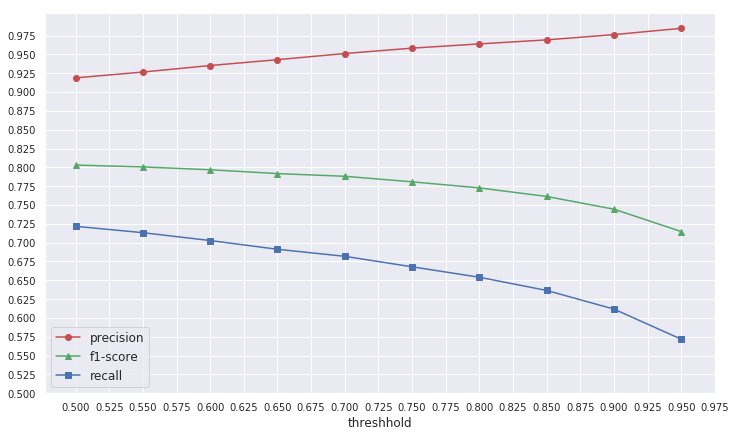

In [0]:
# red dashes, blue squares and green triangles
plt.figure(figsize=(12, 7))
plt.plot(threshholds, precision_arr, '-ro', label='precision')
plt.plot(threshholds, f1_score_arr, '-g^', label='f1-score')
plt.plot(threshholds, recall_arr, '-bs', label='recall')
plt.legend(fontsize=12)
plt.xlabel('threshhold', fontsize=12)
plt.xticks(np.arange(0.5, 1.0, 0.025), fontsize = 10)
plt.yticks(np.arange(0.5, 1.0, 0.025), fontsize = 10)

plt.show()


array([0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 , 0.675, 0.7  ,
       0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875, 0.9  , 0.925,
       0.95 , 0.975])

In [0]:
files_test_isol = collect_specific_files("ENSTDkCl/ISOL/RE", files_test)
files_test_isol

array([['ENSTDkCl/ISOL/RE/MAPS_ISOL_RE_F_S1_M79_ENSTDkCl.wav',
        'ENSTDkCl/ISOL/RE/MAPS_ISOL_RE_F_S1_M79_ENSTDkCl.mid',
        'ENSTDkCl/ISOL/RE/MAPS_ISOL_RE_F_S1_M79_ENSTDkCl.txt'],
       ['ENSTDkCl/ISOL/RE/MAPS_ISOL_RE_F_S0_M102_ENSTDkCl.wav',
        'ENSTDkCl/ISOL/RE/MAPS_ISOL_RE_F_S0_M102_ENSTDkCl.mid',
        'ENSTDkCl/ISOL/RE/MAPS_ISOL_RE_F_S0_M102_ENSTDkCl.txt'],
       ['ENSTDkCl/ISOL/RE/MAPS_ISOL_RE_P_S0_M74_ENSTDkCl.wav',
        'ENSTDkCl/ISOL/RE/MAPS_ISOL_RE_P_S0_M74_ENSTDkCl.mid',
        'ENSTDkCl/ISOL/RE/MAPS_ISOL_RE_P_S0_M74_ENSTDkCl.txt'],
       ['ENSTDkCl/ISOL/RE/MAPS_ISOL_RE_P_S0_M69_ENSTDkCl.wav',
        'ENSTDkCl/ISOL/RE/MAPS_ISOL_RE_P_S0_M69_ENSTDkCl.mid',
        'ENSTDkCl/ISOL/RE/MAPS_ISOL_RE_P_S0_M69_ENSTDkCl.txt'],
       ['ENSTDkCl/ISOL/RE/MAPS_ISOL_RE_F_S1_M30_ENSTDkCl.wav',
        'ENSTDkCl/ISOL/RE/MAPS_ISOL_RE_F_S1_M30_ENSTDkCl.mid',
        'ENSTDkCl/ISOL/RE/MAPS_ISOL_RE_F_S1_M30_ENSTDkCl.txt'],
       ['ENSTDkCl/ISOL/RE/MAPS_ISOL_RE_F_S0_M45